# Ricerca della regione centromerica in un cromosoma

Partendo dalla sequenza di un cromosoma e ipotizzando di non avere informazioni sulla posizione del centromero, la si cerca nella sequenza cercando "la zona con più ripetizioni".

Il processo descritto in letteratura prevede i seguenti passi:
- per farlo si divide il cromosoma in blocchi da _n_ basi (`NUM_BP_FINESTRA`);
- per ogni blocco si confrontano tra loro tutte le sottosequenze di lunghezza _k_ (`NUM_BASI_MER`);
- si marcano i blocchi in cui vengono trovate in proporzione più di _r_ (`PERCENTUALE`) sequenze non uniche.

__Nota__: il processo come descritto presenta un'ambiguità, ovvero non è chiaro se la proporzione tra sequenze non uniche ed il totale debba essere calcolata considerando i due insiemi come tali o come multi-insiemi (considerando il numero di copie di una sequenza); nel primo caso si tratta di un rapporto tra due quantità variabilie, mentre nel secondo caso la quantità quoziente è costante per tutti i blocchi (pari a _n - k + 1_).
Il presente script si confà alla prima delle due interpretazioni. 


In [252]:
import re
import math
import numpy as np
import matplotlib.pyplot as plt

## Valori delle costanti suggeriti in letteratura


In [253]:
NUM_BP_FINESTRA = 1000
NUM_SEQUENZE = 5
NUM_BASI_MER = 12
PERCENTUALE = 0.1

## Rappresentazione delle sottosequenze di lunghezza _k_

Il numero di ripetizioni di ciascuna sequenza verrà mantenuto in memoria in un array di interi.
Ogni posizione dell'array corrisponde ad una diversa sequenza di lunghezza _k_.
Poichè ogni base può assumere quattro valori, una sequenza può essere rappresentata con _2k_ bit.
L'array avrà quindi _2^2k_ posizioni ed occuperà _2^(2k+1)_ byte.

Per _k_ minori di 16, che sono i casi che ci interessano, una sequenza può essere rappresentata come intero (se _k_ < 16 vengono utilizzati i _2k_ bit meno significativi).

Di seguito vengono definiti i dizionari per fare la conversione tra sequenze di basi rappresentate come caratteri e codifica in base 4.


In [254]:
BASE_CODE = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
BASE_CHAR = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}

Le funzioni `seqAsInt()` e `seqToChars` convertono da sequenza di caratteri a intero e viceversa.
Per passare da intero a stringa è necessario fornire la lunghezza della sequenza: visto che lo 0 è utilizzato per rappresentare la base A, non sarebbe alrimenti possibile distinguerlo da posizioni in cui non vi sono caratteri.

In [255]:
def seqAsInt(dnaStr):
    # seqLength = len(dnaStr)
    if len(dnaStr) == 0:
        return 0
    dnaInt = BASE_CODE[dnaStr[0]]
    for dnaBaseChar in dnaStr[1:]:
        dnaInt = dnaInt << 2 | BASE_CODE[dnaBaseChar]
    return dnaInt

In [256]:
def seqToChars(seqAsInt, seqSize):
    seqStr = ''
    for seqPos in range(seqSize):
        seqStr = BASE_CHAR[seqAsInt & 3] + seqStr
        seqAsInt = seqAsInt >> 2
    return seqStr

La funzione `appendToSeq()` aggiunge una base alla fine di una sequenza, shiftando le altri basi di una posizione a sinistra, mantenendo la rappresentazione come intero.
Permette di implementare in forma efficiente una sliding window di lunghezza fissa _k_ su una sequenza più grande (che sarà un blocco di _n_ basi).
Per il suddetto motivo, anche in questo caso è necessario passare la lunghezza della sequenza (_k_).

In [257]:
def appendToSeq(seqAsInt, dnaBaseChar, seqSize):
    return seqAsInt << 2 & (2 ** (seqSize * 2) - 1) | BASE_CODE[dnaBaseChar]

In [258]:
appendToSeq(53,'T',12)

215

In [259]:
seqToChars(seqAsInt('ACTGTTCACA'), 10)

'ACTGTTCACA'

In [260]:
seqToChars(seqAsInt('ACTGACTTCACA'), 12)

'ACTGACTTCACA'

In [261]:
seqToChars(appendToSeq(seqAsInt('ACTGACTTCACA'),'C', 12), 12)

'CTGACTTCACAC'

## Funzione per il calcolo delle ripetizioni per ogni blocco

La seguente funzione scorre una sequenza in input (`seqStr`) e calcola la proporzione di sequenze diverse di lunghezza _k_ (`kmerSize`) ripetute almeno due volte rispetto al numero totale di sequenze diverse.

In [262]:
def uniqueKmersRepeatedRatio(seqStr, kmerSize):
    kmerCounts = np.zeros((2 ** (kmerSize * 2),), dtype=int)
    uniqueKmersFound = 0
    uniqueKmersRepeated = 0
    if (len(seqStr) < kmerSize):
        return kmerCounts
    currKmer = seqAsInt(seqStr[:kmerSize - 1])
    for seqChar in seqStr[kmerSize - 1:]:
        currKmer = appendToSeq(currKmer, seqChar, kmerSize)
        kmerCounts[currKmer] += 1
        if (kmerCounts[currKmer] == 1):
            uniqueKmersFound += 1 
        if (kmerCounts[currKmer] == 2):
            uniqueKmersRepeated += 1
    return uniqueKmersRepeated / uniqueKmersFound

## Funzione per il calcolo delle ripetizioni per ogni blocco

La seguente funzione prende una sequenza (per esempio un intero cromosoma), la divide in blocchi da _n_ (`blockSize`) basi.
Su ognuno di questi blocchi viene eseguita la funzione precedente e calcolata la proporzione di sequenze ripetute. 
L'output è un array np con la proporzione per ciascuno dei blocchi.

In [263]:
def repeatedRatioByBlock(seq, blockSize, kmerSize):
    windowIndexes = range(math.ceil(len(seq)/blockSize))
    rateOfRepeatedKmersByWindow = np.empty(len(windowIndexes))
    for windowIndex in windowIndexes: 
        windowStart = blockSize * windowIndex
        window = seq[windowStart: min(windowStart + blockSize, len(seq))]
        rateOfRepeatedKmersByWindow[windowIndex] = uniqueKmersRepeatedRatio(window, kmerSize)
    return rateOfRepeatedKmersByWindow

In [264]:
f = open('chr_21.fasta')
app = f.readline()
cromosoma = f.read() #cromosoma senza la prima riga
cromosoma = re.sub("\n","",cromosoma)
cromosoma = cromosoma.upper()

In [265]:
%%time
rateOfRepeatedKmersByWindow = repeatedRatioByBlock(cromosoma, NUM_BP_FINESTRA, NUM_BASI_MER)

CPU times: user 1min 44s, sys: 2min 20s, total: 4min 5s
Wall time: 4min 5s


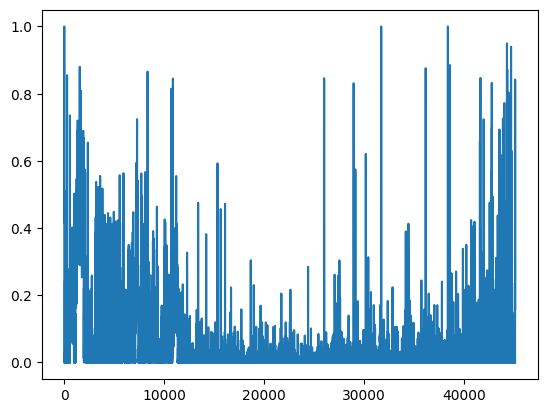

In [266]:
plt.plot(rateOfRepeatedKmersByWindow)

In [240]:
windowWitHighRepetition = np.where(rateOfRepeatedKmersByWindow >= 0.1, 1, 0)
startRegionIndices = np.where(np.diff(windowWitHighRepetition) > 0)[0]
endRegionIndices = np.where(np.diff(windowWitHighRepetition) < 0)[0]
if windowWitHighRepetition[0] == 1:
    startRegionIndices = np.insert(startRegionIndices, 0, 0)
if windowWitHighRepetition[-1] == 1:
    endRegionIndices = np.append(endRegionIndices, len(windowWitHighRepetition) - 1)
regionSizes = endRegionIndices - startRegionIndices

In [241]:
highRepetitionRegions = np.transpose(np.vstack((startRegionIndices, endRegionIndices, regionSizes)))

In [242]:
np.max(regionSizes)

836

In [243]:
np.transpose(np.vstack((startRegionIndices, endRegionIndices, regionSizes)))[regionSizes == 836]

array([[1116, 1952,  836]])

In [244]:
windowWitHighRepetition

array([1, 1, 1, ..., 1, 1, 1])

In [245]:
np.asarray(highRepetitionRegions)

array([[    0,     2,     2],
       [   68,    69,     1],
       [   75,    76,     1],
       ...,
       [44798, 44800,     2],
       [45077, 45078,     1],
       [45085, 45090,     5]])

In [246]:
np.savetxt("highRepetionsRegions.csv", np.asarray(highRepetitionRegions), fmt="%d", delimiter=',')

In [247]:
np.savetxt("windowsWithHighRepetition.csv", np.asarray(windowWitHighRepetition), fmt="%d", delimiter=',')